# Train Model



## Set parameters that will control the execution

In [1]:
data_dir = "../_DATA/CarND/p3_behavioral_cloning/r_001/"
image_dir = "IMG/"
driving_data_csv = "driving_log_normalized.csv"
model_dir = "../_DATA/MODELS/"
model_name = "model_p3_14x64x3_"
batch_size = 256
nb_epoch = 40 
model_to_continue_training = "previous_model.h5"
previous_trained_epochs = 30

# Allocate only a fraction of memory to TensorFlow GPU process

In [2]:
# https://github.com/aymericdamien/TensorFlow-Examples/issues/38#issuecomment-265599695
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6) # try range from 0.333 ot .9
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

#### Show available CPU and GPU(s)
from tensorflow.python.client import device_lib
def get_available_CPU_GPU():
    devices = device_lib.list_local_devices()
    #return [x.name for x in devices if x.device_type == 'CPU']
    return [x.name for x in devices ]

print(get_available_CPU_GPU())

['/cpu:0', '/gpu:0']


# Fetch data from CSV file

In [3]:
from  DataHelper import read_csv
csv_path = data_dir + driving_data_csv
print("csv_path", csv_path)
headers, data = read_csv(data_dir + driving_data_csv)

Using TensorFlow backend.


csv_path ../_DATA/CarND/p3_behavioral_cloning/r_001/driving_log_normalized.csv
Number of imported CSV rows: 11723


# Split data into training, testing and validation sets

In [4]:
from DataHelper import split_random
training, testing, validation = split_random(data, percent_train=75, percent_test=15) 

print("training", training.shape)
print("testing", testing.shape)
print("validation", validation.shape)

percent_validation 10
training (8792, 7)
testing (1759, 7)
validation (1171, 7)


# Fetch and visualize training steering angles

I would like to train a car on the set that has a nice bell curve distribution of values:
- I can drive the car on the track backwards
- I can flip each image (and value)

min_value -0.842961
max_value 0.965902
spread 1.80886
recommended number of classes 181


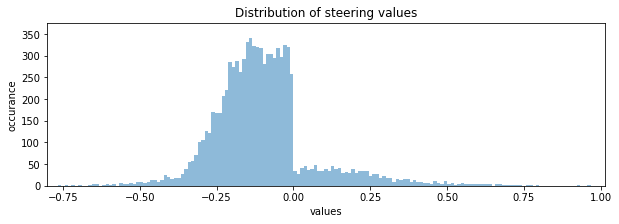

In [5]:
from DataHelper import plot_histogram, get_steering_values, find_nearest
steering_angles = get_steering_values(training)
plot_histogram("steering values", steering_angles, change_step=0.01)

# Extract image names

In [6]:
from DataHelper import get_image_center_values 
image_names = get_image_center_values(training)
print("image count", image_names.shape[0])
print(image_names[1])

image count 8792
center_2017_01_21_00_27_34_405.jpg


# Create a list of image paths

In [7]:
image_paths = []
for image_name in image_names:
    image_paths.extend([data_dir + image_dir + image_name])
print(image_paths[1]) 

../_DATA/CarND/p3_behavioral_cloning/r_001/IMG/center_2017_01_21_00_27_34_405.jpg
